## Import Library

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import pickle
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from scipy import optimize
from sklearn.naive_bayes import GaussianNB
import time

## Import Pre-processed Data

In [3]:
!mkdir -p content/data
# Download all files
file_ids = [
    '1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq',  # X_train
    '1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1',  # X_train_resampled
    '1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR',  # X_test
    '1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ',  # X_test_resampled
    '1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z',  # Y_train
    '1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf',  # Y_train_resampled
    '1-CUpVhcZ6-Qop7R9Z6Btb2gEf7f0XgGy'   # Y_test
]

file_paths = [
    'content/data/X_train.pkl',
    'content/data/X_train_resampled.pkl',
    'content/data/X_test.pkl',
    'content/data/X_test_resampled.pkl',
    'content/data/Y_train.pkl',
    'content/data/Y_train_resampled.pkl',
    'content/data/Y_test.pkl'
]
for file_id, file_path in zip(file_ids, file_paths):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq
To: /content/content/data/X_train.pkl
100%|██████████| 21.4M/21.4M [00:00<00:00, 97.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1
To: /content/content/data/X_train_resampled.pkl
100%|██████████| 18.7M/18.7M [00:00<00:00, 79.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR
To: /content/content/data/X_test.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 40.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ
To: /content/content/data/X_test_resampled.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 156MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z
To: /content/content/data/Y_train.pkl
100%|██████████| 2.79M/2.79M [00:00<00:00, 196MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf
To: /content/

In [4]:
# Không dùng đến các cột _scaled, mà sẽ đi chuẩn hóa ở phía dưới
X_train = pd.read_pickle('content/data/X_train.pkl')
X_train_resampled = pd.read_pickle('content/data/X_train_resampled.pkl')
X_test = pd.read_pickle('content/data/X_test.pkl')
X_test_resampled = pd.read_pickle('content/data/X_test_resampled.pkl')
y_train = pd.read_pickle('content/data/Y_train.pkl')
y_train_resampled = pd.read_pickle('content/data/Y_train_resampled.pkl')
y_test = pd.read_pickle('content/data/Y_test.pkl')

In [5]:
result_acc = []
result_recall = []
pred_time = []

## 1. Naive Bayes - Thư viện

### 1.1 No resampled

In [6]:
nb_model = GaussianNB()

# Định nghĩa các tham số mà GridSearch sẽ tìm kiếm
param_grid_nb = {
    'var_smoothing': [0.01, 0.1, 1, 2, 3, 5, 10]  # Tham số điều chỉnh độ trơn mượt
}

# Khởi tạo GridSearchCV
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')

# Thực hiện GridSearch trên tập huấn luyện
grid_search_nb.fit(X_train, y_train)

# Lấy kết quả từ GridSearch
results_nb = grid_search_nb.cv_results_
mean_accuracy_nb = results_nb['mean_test_score']*100
std_accuracy_nb = results_nb['std_test_score']
print("Best parameters:", grid_search_nb.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'var_smoothing': 3}


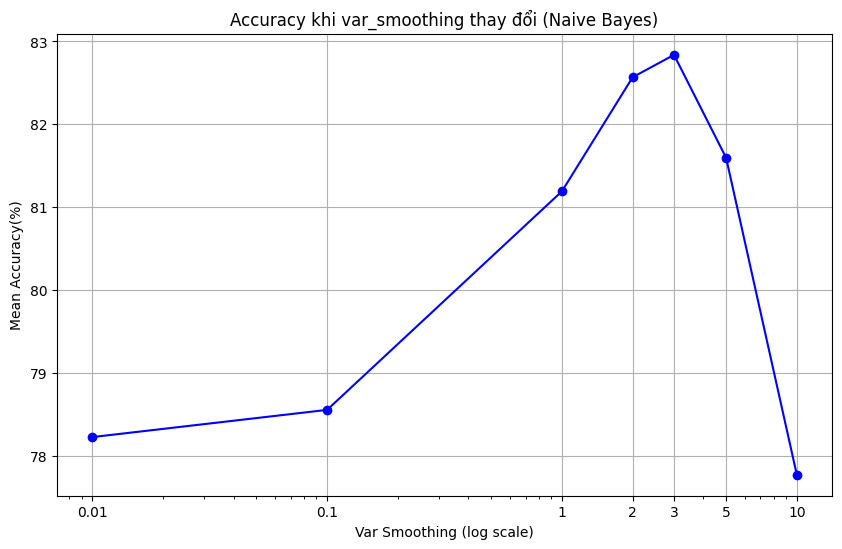

In [7]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.errorbar(param_grid_nb['var_smoothing'], mean_accuracy_nb, yerr=std_accuracy_nb, fmt='o-', color='blue')
plt.xscale('log')  # Sử dụng log scale để hiển thị var_smoothing
plt.xticks(param_grid_nb['var_smoothing'], labels=[str(c) for c in param_grid_nb['var_smoothing']])
plt.xlabel("Var Smoothing (log scale)")
plt.ylabel("Mean Accuracy(%)")
plt.title("Accuracy khi var_smoothing thay đổi (Naive Bayes)")
plt.grid()
plt.show()

In [8]:
# Train mô hình với tham số tốt nhất vừa tìm được
nb=GaussianNB(var_smoothing=3)
nb.fit(X_train,y_train)

# Dự đoán trên tập Test
start_time = time.time()
y_pred = nb.predict(X_test)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 0.0187 seconds
Accuracy on Test set: 83.19%


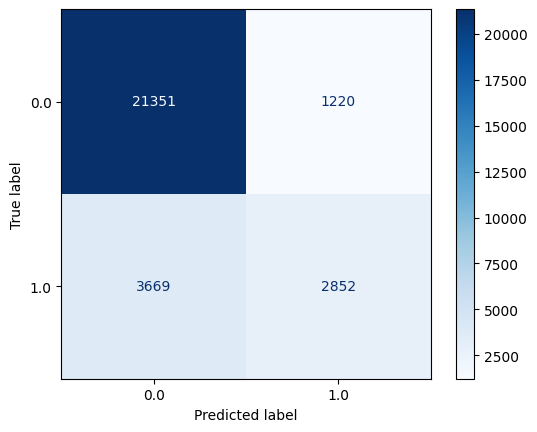

<Figure size 1200x1200 with 0 Axes>

In [9]:
ConfusionMatrixDisplay.from_estimator(nb, X_test, y_test, cmap='Blues')
plt.figure(figsize=(12, 12))
plt.show();

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90     22571
         1.0       0.70      0.44      0.54      6521

    accuracy                           0.83     29092
   macro avg       0.78      0.69      0.72     29092
weighted avg       0.82      0.83      0.82     29092



In [11]:
recall = recall_score(y_test, nb.predict(X_test), average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])
result_recall.append(recall)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.43735623370648674
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9459483407912809


### 1.2 Resampled

In [12]:
nb_model = GaussianNB()

# Định nghĩa các tham số mà GridSearch sẽ tìm kiếm
param_grid_nb = {
    'var_smoothing': [0.01, 0.1, 1, 2, 3, 5, 10]  # Tham số điều chỉnh độ trơn mượt
}

# Khởi tạo GridSearchCV
grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')

# Thực hiện GridSearch trên tập huấn luyện
grid_search_nb.fit(X_train_resampled, y_train_resampled)

# Lấy kết quả từ GridSearch
results_nb = grid_search_nb.cv_results_
mean_accuracy_nb = results_nb['mean_test_score']*100
std_accuracy_nb = results_nb['std_test_score']
print("Best parameters:", grid_search_nb.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'var_smoothing': 3}


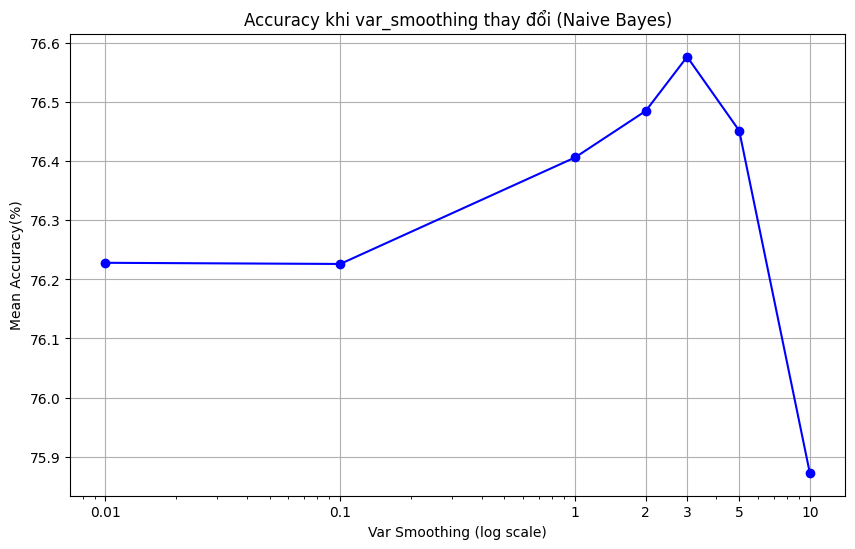

In [13]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.errorbar(param_grid_nb['var_smoothing'], mean_accuracy_nb, yerr=std_accuracy_nb, fmt='o-', color='blue')
plt.xscale('log')  # Sử dụng log scale để hiển thị var_smoothing
plt.xticks(param_grid_nb['var_smoothing'], labels=[str(c) for c in param_grid_nb['var_smoothing']])
plt.xlabel("Var Smoothing (log scale)")
plt.ylabel("Mean Accuracy(%)")
plt.title("Accuracy khi var_smoothing thay đổi (Naive Bayes)")
plt.grid()
plt.show()

In [14]:
nb_res=GaussianNB(var_smoothing=3)
nb_res.fit(X_train_resampled,y_train_resampled)

# Dự đoán trên tập Test
start_time = time.time()
y_pred_resampled = nb_res.predict(X_test_resampled)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred_resampled) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 0.0094 seconds
Accuracy on Test set: 77.89%


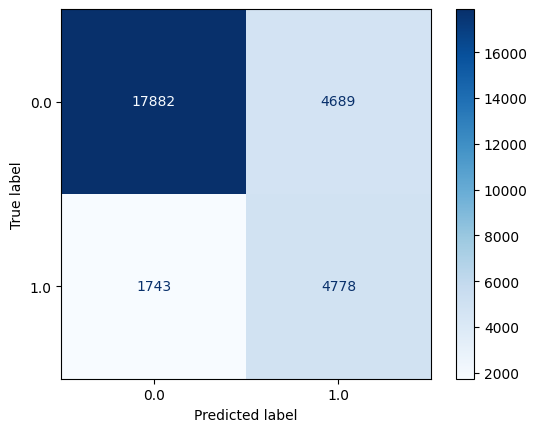

<Figure size 1200x1200 with 0 Axes>

In [15]:
ConfusionMatrixDisplay.from_estimator(nb_res, X_test_resampled, y_test, cmap='Blues')
plt.figure(figsize=(12, 12))
plt.show();

In [16]:
print(classification_report(y_test, y_pred_resampled))

              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85     22571
         1.0       0.50      0.73      0.60      6521

    accuracy                           0.78     29092
   macro avg       0.71      0.76      0.72     29092
weighted avg       0.82      0.78      0.79     29092



In [17]:
recall = recall_score(y_test, y_pred_resampled, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])
result_recall.append(recall)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.732709707100138
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.7922555491559966


## 2. Naive Bayes - Tự code

### 2.1 No resampled

In [18]:
classes = np.unique(y_train)  # Các lớp
mean = {}  # Trung bình cho mỗi lớp
var = {}  # Phương sai cho mỗi lớp
priors = {}  # Prior probabilities cho mỗi lớp
classes

array([0., 1.])

In [19]:
# Hàm tính xác suất Gaussian (PDF)
def gaussian_pdf(x, mean, var):
    coef = 1.0 / np.sqrt(2.0 * np.pi * var)
    exp = np.exp(-((x - mean) ** 2) / (2.0 * var))
    return coef * exp

# Hàm dự đoán
def predict(X):
    predictions = []
    for x in X:
        class_probs = {}
        for c in classes:
            # Tính log(P(C)) + log(P(X|C))
            prior = np.log(priors[c])
            likelihood = np.sum(np.log(gaussian_pdf(x, mean[c], var[c])))
            class_probs[c] = prior + likelihood
        # Chọn lớp có xác suất lớn nhất
        predictions.append(max(class_probs, key=class_probs.get))
    return np.array(predictions)

In [20]:
for c in classes:
    X_c = X_train[y_train.to_numpy() == c]  # Lấy các mẫu thuộc lớp c
    mean[c] = np.mean(X_c, axis=0)  # Trung bình theo từng đặc trưng
    var[c] = np.var(X_c, axis=0)  # Phương sai theo từng đặc trưng
    priors[c] = X_c.shape[0] / X_train.shape[0]  # Xác suất tiên nghiệm P(C)

In [21]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()

In [22]:
# Dự đoán trên tập Test
start_time = time.time()
y_pred_by_hand = predict(X_test)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")

acc = accuracy_score(y_test, y_pred_by_hand) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

print(classification_report(y_test, y_pred_by_hand))

Time to predict: 65.2129 seconds
Accuracy on Test set: 78.18%
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85     22571
         1.0       0.51      0.72      0.60      6521

    accuracy                           0.78     29092
   macro avg       0.71      0.76      0.72     29092
weighted avg       0.82      0.78      0.79     29092



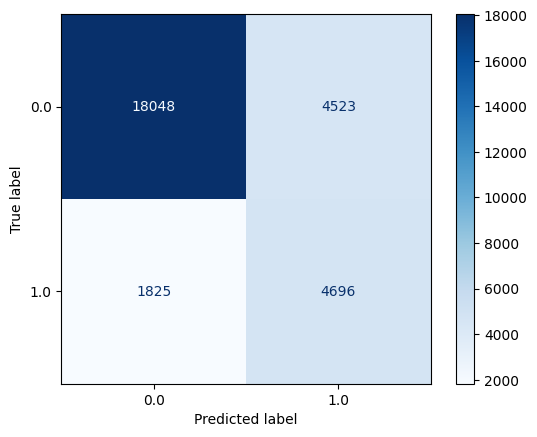

<Figure size 1200x1200 with 0 Axes>

In [23]:
cm = confusion_matrix(y_test, y_pred_by_hand)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [24]:
recall_s = recall_score(y_test, y_pred_by_hand, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là', recall_s[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là 0.7201349486275112
Tỉ lệ dự đoán đúng ngày mai không có mưa là 0.7996101191794781


### 2.2 Resampled

In [25]:
classes = np.unique(y_train_resampled)  # Các lớp
mean = {}  # Trung bình cho mỗi lớp
var = {}  # Phương sai cho mỗi lớp
priors = {}  # Prior probabilities cho mỗi lớp
classes

array([0., 1.])

In [26]:
for c in classes:
    X_c = X_train_resampled[y_train_resampled.to_numpy() == c]  # Lấy các mẫu thuộc lớp c
    mean[c] = np.mean(X_c, axis=0)  # Trung bình theo từng đặc trưng
    var[c] = np.var(X_c, axis=0)  # Phương sai theo từng đặc trưng
    priors[c] = X_c.shape[0] / X_train_resampled.shape[0]  # Xác suất tiên nghiệm P(C)

In [27]:
X_train_resampled = X_train_resampled.to_numpy()
y_train_resampled = y_train_resampled.to_numpy()
X_test_resampled = X_test_resampled.to_numpy()

In [28]:
# Dự đoán trên tập Test
start_time = time.time()
y_pred_by_hand = predict(X_test_resampled)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")

acc = accuracy_score(y_test, y_pred_by_hand) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

print(classification_report(y_test, y_pred_by_hand))


Time to predict: 57.1668 seconds
Accuracy on Test set: 75.99%
              precision    recall  f1-score   support

         0.0       0.92      0.76      0.83     22571
         1.0       0.48      0.76      0.59      6521

    accuracy                           0.76     29092
   macro avg       0.70      0.76      0.71     29092
weighted avg       0.82      0.76      0.78     29092



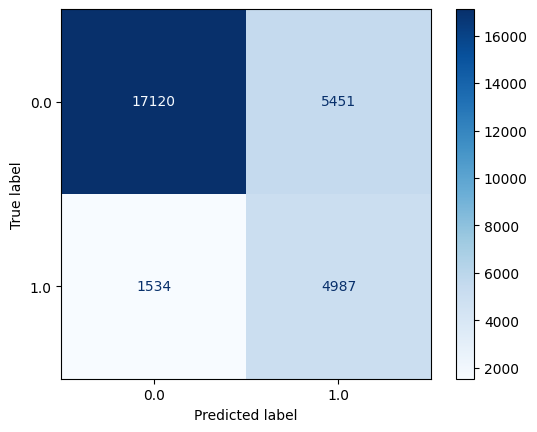

<Figure size 1200x1200 with 0 Axes>

In [29]:
cm = confusion_matrix(y_test, y_pred_by_hand)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [30]:
recall_s = recall_score(y_test, y_pred_by_hand, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là', recall_s[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là', recall_s[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là 0.7647600061340285
Tỉ lệ dự đoán đúng ngày mai không có mưa là 0.758495414469895


## 3. Model Comparing

In [31]:
result_acc

[83.19469269902379, 77.89082909390898, 78.17956826619002, 75.98996287639214]

In [32]:
result_recall

[array([0.94594834, 0.43735623]), array([0.79225555, 0.73270971])]

In [33]:
pred_time

[0.018653154373168945,
 0.009408235549926758,
 65.21287846565247,
 57.16684913635254]

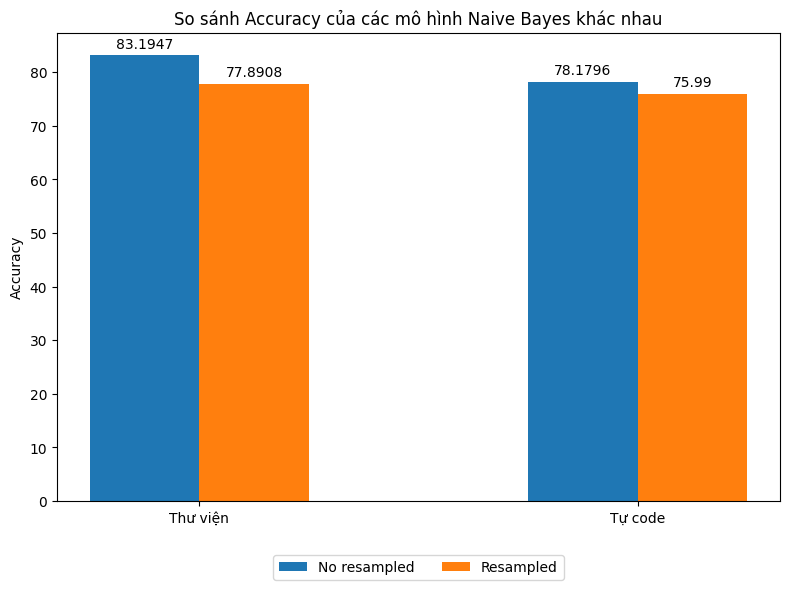

In [34]:
labels = ['Thư viện', 'Tự code']
no_res = [result_acc[0], result_acc[2]]
res = [result_acc[1], result_acc[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('So sánh Accuracy của các mô hình Naive Bayes khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

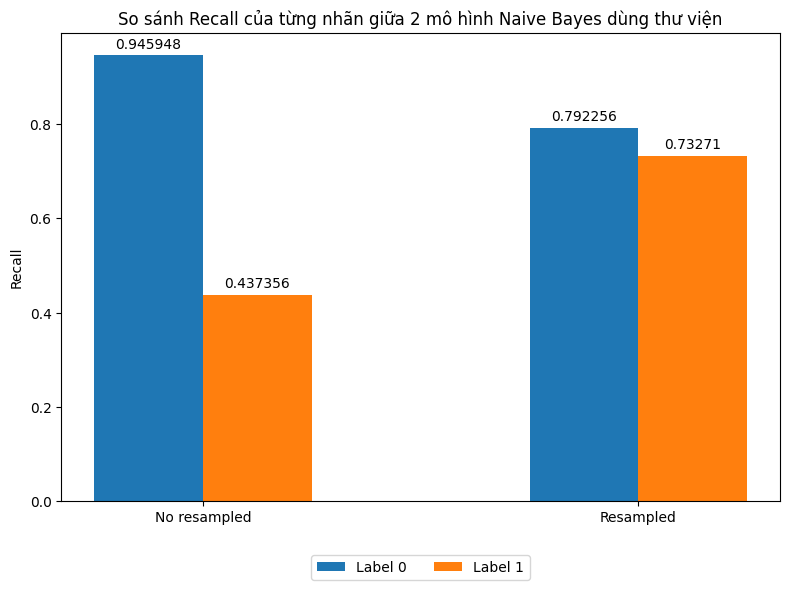

In [35]:
labels = ['No resampled', 'Resampled']
label_0 = [result_recall[0][0], result_recall[1][0]]
label_1 = [result_recall[0][1], result_recall[1][1]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, label_0, width, label='Label 0')
rects2 = ax.bar(x + width/2, label_1, width, label='Label 1')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Recall')
ax.set_title('So sánh Recall của từng nhãn giữa 2 mô hình Naive Bayes dùng thư viện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

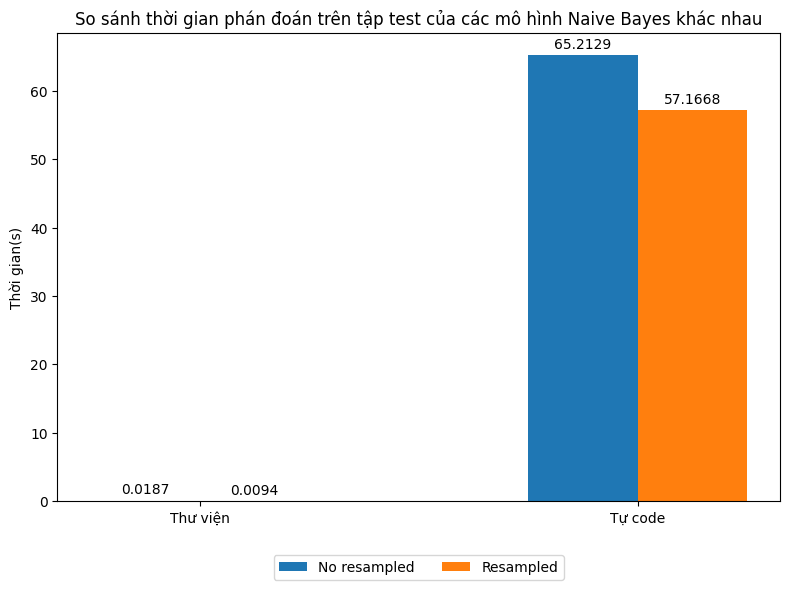

In [36]:
labels = ['Thư viện', 'Tự code']
no_res = [pred_time[0], pred_time[2]]
res = [pred_time[1], pred_time[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Thời gian(s)')
ax.set_title('So sánh thời gian phán đoán trên tập test của các mô hình Naive Bayes khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3, labels=[f"{value:.4f}" for value in no_res])
ax.bar_label(rects2, padding=3, labels=[f"{value:.4f}" for value in res])

fig.tight_layout()

plt.show()

In [38]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Result/Model_Evaluation/3. Naive Bayes.pkl'
with open(file_path, 'wb') as f:
    pickle.dump([result_acc,result_recall,pred_time],f)

Mounted at /content/drive
